In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features
from src.visualization import visualize

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

DIAGS_FALTANTES_PULMON = ["C349", "C348"]

DIAGS_RELEVANTES += DIAGS_FALTANTES_PULMON

In [3]:
# Carga los egresos nacionales
egresos_nacionales = pd.read_csv(
    "../data/processed/ranking_nacional_egresos.csv", sep=";", encoding="latin-1"
)

# Filtra solamente los datos del INT
egresos_torax = egresos_nacionales.query("ESTABLECIMIENTO_SALUD == 112103").copy()

En primer lugar, se filtrarán ambas bases de datos para solamente tener la información de los diagnósticos más relevantes para el INT. Luego de esto, se calculará la cantidad de egresos, dias de estada y pacientes para cada uno de los diagnósticos. Estos insumos serán utilizados para estimar la demanda.

In [4]:
# Filtra solamente los diagnosticos mas relevantes del Torax
egresos_mas_relevantes_nacionales = (
    egresos_nacionales[egresos_nacionales["DIAG1"].isin(DIAGS_RELEVANTES)]
    .query("ANO_EGRESO >= 2017")
    .copy()
)

# Agrupa todos los diagnosticos relacionados a cancer de pulmon a un diagnostico comun
egresos_mas_relevantes_nacionales["DIAG1"] = egresos_mas_relevantes_nacionales["DIAG1"].replace(
    ["C340", "C341", "C342", "C343", "C348", "C349"], "C34"
)

# Filtra solamente los diagnosticos relevantes para el torax
egresos_mas_relevantes_torax = egresos_mas_relevantes_nacionales.query(
    "ESTABLECIMIENTO_SALUD == 112103"
).copy()

In [17]:
def calculate_metrics(df):
    metricas = pd.pivot_table(
        df,
        index="DIAG1",
        columns="ANO_EGRESO",
        values=["n_pacientes_distintos", "n_egresos", "dias_estada_totales"],
        aggfunc="sum",
        fill_value=0,
    ).sort_index()

    return metricas

In [18]:
# Obtiene el resumen de metricas para el estrato nacional
metricas_diags_relevantes_nacionales = calculate_metrics(egresos_mas_relevantes_nacionales)

# Obtiene resumen de metricas para el Torax
metricas_diags_relevantes_torax = calculate_metrics(egresos_mas_relevantes_torax)

In [20]:
metricas_diags_relevantes_torax

dias_estada_totales                   n_egresos                 \
ANO_EGRESO                2017  2018  2019  2020      2017 2018 2019 2020   
DIAG1                                                                       
C33X                         4    22    34    64         1    1    4    7   
C34                       4567  4547  4611  1846       358  408  403  151   
C381                       234   253   223    31        15   21   19    5   
C384                       144    62   159    17         9    9   10    3   
C450                       232   243   113    79        23   27    8    5   
C780                       458   514   450    97        57   63   62   15   
C782                       411   615   441   556        29   53   39   51   
D143                       465   373   184    49        32   40   28    6   
D381                       262   465   713   304        36   85   97   46   
E848                       377   602   574   366        26   35   41   23   
I080                       612   763   493   339        38   42   42   17   
I081                       511   981   797   242        29   44   42   14   
I340                       815   804   569   454        40   48   37   28   
I350                      1964  2084  1999  1126       118  163  148   83   
I351                       484   737   680   508        37   52   49   27   
I352                       324   446   476   369        31   26   37   21   
I420                       396   822   754   310        33   34   30   10   
I456                        82    27    63    16        44   25   29   16   
I472                       117   119   106   150        22   29   26   24   
I495                       173   148   267    70        51   64   91   23   
I710                       379   352   483   530        19   24   25   28   
I712                       165   139   170   341         8   13   15   29   
J398                       124    69   150   729        19   10    9   16   
J47X                       643   843   848   294        53   47   42   20   
J679                       864   789   969    94        77   70   69   10   
J841                      1564  1286  1799   930       108  108  122   58   
J848                       278   399   519   275        25   53   52   27   
J849                       343   245   233    87        43   23   27   10   
J860                       784   793    97   157        22   61   11   10   
J869                      1181   520   408   322        39   27   23   18   
J90X                       538   685   536   281        54   72   57   27   
J91X                         0    10     0     0         0    1    0    0   
J931                       417   266   226    70        21   30   19    5   
J955                       609   225   451   214        53   35   44   22   
J980                        40    73     7    54         4    6    2    7   
M348                       290   357   421    63        21   29   27    2   
Q211                       170    97   131   122        47   32   38   22   
Q231                         1     6    18   263         1    1    2   19   
Q676                        46    69    33    24         4   10    5    4   
T820                       174   156   348   475        10   17   25   26   
T821                       458   201   199   112        40   28   35   18   
Z450                       141   243   190    78        71  132  137   57   

           n_pacientes_distintos                 
ANO_EGRESO                  2017 2018 2019 2020  
DIAG1                                            
C33X                           1    1    4    4  
C34                          290  319  324  140  
C381                          13   18   19    4  
C384                           9    8    9    3  
C450                          17   18    7    5  
C780                          52   54   52   15  
C782                          27   48   34   48  
D143                          30   36   25   

In [16]:
metricas_diags_relevantes_nacionales["dias_estada_totales"] / metricas_diags_relevantes_nacionales["n_egresos"]

ANO_EGRESO,2017,2018,2019,2020
DIAG1,,,,
C33X,17.040000,10.722222,9.117647,9.714286
C34,10.146588,9.675897,8.738184,8.697565
C381,11.560976,9.829268,11.057692,7.595238
C384,15.692308,10.204545,9.769231,7.279070
C450,8.160494,7.447368,7.466667,7.471698
C780,10.651475,8.833773,8.213953,8.852761
C782,11.503401,9.781915,10.094787,9.175000
D143,7.224719,5.903382,4.762500,4.752212
D381,8.435805,8.369735,8.186544,6.942207


In [ ]:
# Importa los casos teoricos por cada problema de salud
casos_teoricos = pd.read_excel("../data/interim/casos_teoricos_diagnosticos.xlsx")
casos_teoricos["Diagnostico"] = casos_teoricos["Diagnostico"].str.split("-").str[0].str.strip()
casos_teoricos = casos_teoricos.set_index("Diagnostico")

# Obtiene los casos en el estrato nacional
casos_nacionales = casos_teoricos.query("Estrato == 'Pais' and Estadística == 'Incidencia'").copy()
casos_nacionales_del_2017_al_2020 = casos_nacionales[[f"Poblacion {i}" for i in range(2017, 2021)]]

In [ ]:
# Une la cantidad de casos teoricos y reales
union_de_pacientes_teoricos_y_vistos = casos_nacionales_del_2017_al_2020.merge(
    resumen_egresos_mas_relevantes_nacionales["n_pacientes_distintos"],
    how="left",
    left_index=True,
    right_index=True,
)

# Renombra las columnas
niveles_columnas = [
    ("poblacion_teorica", "2017"),
    ("poblacion_teorica", "2018"),
    ("poblacion_teorica", "2019"),
    ("poblacion_teorica", "2020"),
    ("poblacion_vista", "2017"),
    ("poblacion_vista", "2018"),
    ("poblacion_vista", "2019"),
    ("poblacion_vista", "2020"),
]

union_de_pacientes_teoricos_y_vistos.columns = pd.MultiIndex.from_tuples(niveles_columnas)

# Calcula la cantidad de cumplimiento de los casos teoricos
porcentaje_de_atencion_casos_teoricos = union_de_pacientes_teoricos_y_vistos["poblacion_vista"].sum(
    axis=1
) / union_de_pacientes_teoricos_y_vistos["poblacion_teorica"].sum(axis=1)

In [ ]:
proyeccion_de_casos_a_atender = casos_nacionales[[f"Poblacion {i}" for i in range(2017, 2036)]].mul(
    porcentaje_de_atencion_casos_teoricos, axis=0
)

In [ ]:
# Obtiene egresos por caso por diagnostico
egresos_por_persona_nacionales = resumen_egresos_mas_relevantes_nacionales["n_egresos"].sum(
    axis=1
) / resumen_egresos_mas_relevantes_nacionales["n_pacientes_distintos"].sum(axis=1)

# Obtiene dias de estada por egreso
dias_de_estada_por_egreso_nacionales = resumen_egresos_mas_relevantes_nacionales[
    "dias_estada_totales"
].sum(axis=1) / resumen_egresos_mas_relevantes_nacionales["n_egresos"].sum(axis=1)

# Obtiene porcentaje de atendimiento del torax de egresos nacionales
porcentaje_de_atendimiento_torax = resumen_egresos_mas_relevantes_torax["n_egresos"].sum(
    axis=1
) / resumen_egresos_mas_relevantes_nacionales["n_egresos"].sum(axis=1)

# Obtiene dias de estada por egresos
dias_de_estada_por_egreso_torax = resumen_egresos_mas_relevantes_torax["dias_estada_totales"].sum(
    axis=1
) / resumen_egresos_mas_relevantes_torax["n_egresos"].sum(axis=1)

In [ ]:
# Obtiene la cantidad de egresos, dias de estada y camas por la proyeccion
proyeccion_de_egresos_nacionales = proyeccion_de_casos_a_atender.mul(
    egresos_por_persona_nacionales, axis=0
)
proyeccion_de_egresos_int = proyeccion_de_egresos_nacionales.mul(
    porcentaje_de_atendimiento_torax, axis=0
)
proyeccion_de_dias_de_estada_int = proyeccion_de_egresos_int.mul(
    dias_de_estada_por_egreso_torax, axis=0
)
proyeccion_de_camas_a_tener_int = proyeccion_de_dias_de_estada_int / 365.25

<Axes: >

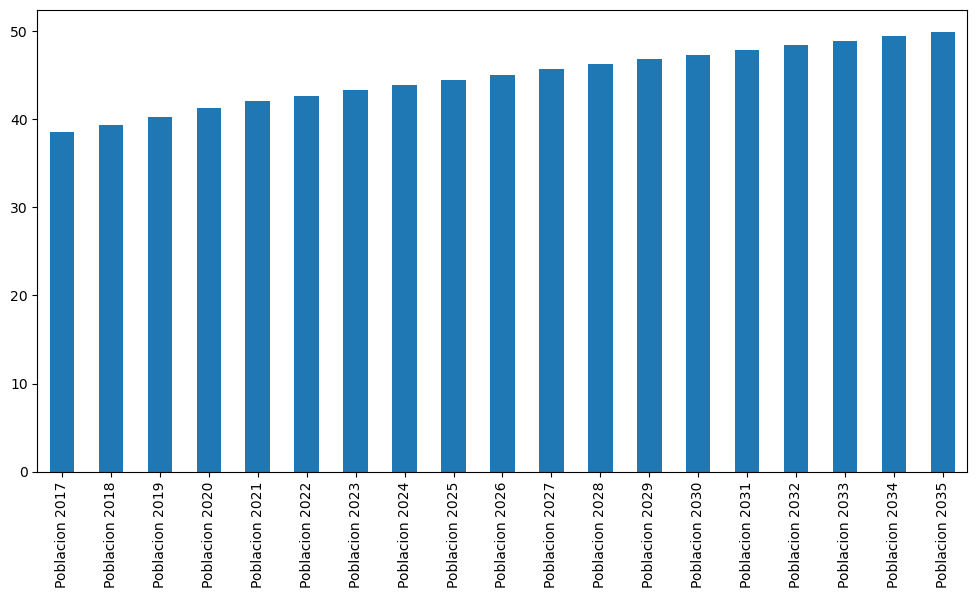

In [ ]:
proyeccion_de_camas_a_tener_int.sum().plot(kind="bar")